In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tensorflow.python.ops.variables import Variable
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import f1_score
import numpy as np
from PIL import Image
import datetime
import time
%matplotlib inline
%load_ext tensorboard

In [ ]:
tf.compat.v1.enable_v2_behavior()
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D,\
      Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD

In [ ]:
import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
import warnings
warnings.simplefilter("ignore", UserWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

 Датасет CIFAR10 містить 60,000 кольорових фото розмірністю 32×32 пікселі,  усього 10 значень цільової змінної:


  0. airplane
  1. automobile
  2. bird
  3. cat
  4. deer
  5. dog
  6. frog
  7. horse
  8. ship
  9. truck

In [ ]:
# розмірності датасетів
assert X_train.shape == (50000, 32, 32, 3)
assert X_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

# one-hot кодування для цільової змінної
y_train = to_categorical(y_train).astype(np.int32)
y_test = to_categorical(y_test).astype(np.int32)

X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

X_train, X_valid, y_train, y_valid = train_test_split(X_train,
                                                    y_train,
                                                    test_size=.2, random_state=42)

Оберемо 9 картинок з датасету і зобразимо їх.

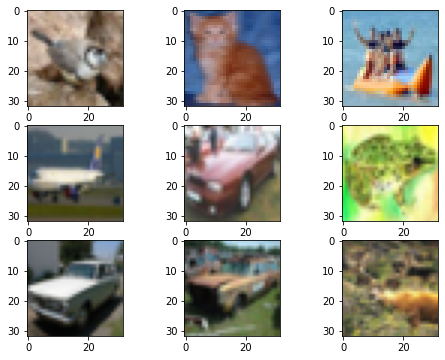

In [ ]:
plt.figure(figsize = (8,6))
for i in range(9):
	plt.subplot(330 + 1 + i)
	plt.imshow(X_train[i+90])
plt.show()

>**Реалізація на Tensorflow1**

In [ ]:
def reset_graph(seed = 42):
  tf.reset_default_graph()
  tf.set_random_seed(seed)
  np.random.seed(seed)

reset_graph()

In [ ]:
# прописуємо шляхи до папок, де зберігатимемо логи з процесу навчання
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M")
acc_log_dir = '/content/drive/My Drive/Colab Notebooks/Tf_CNN/logs/' + current_time + '/acc'
loss_log_dir = '/content/drive/My Drive/Colab Notebooks/Tf_CNN/logs/' + current_time + '/loss'
acc_writer = tf.summary.FileWriter(acc_log_dir)
loss_writer = tf.summary.FileWriter(loss_log_dir)

In [ ]:
X_train, X_valid = X_train.reshape(-1, 32*32*3), X_valid.reshape(-1, 32*32*3)

In [ ]:
n_inputs = 32*32*3
n_outputs = 10
X = tf.placeholder(tf.float32, [None, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])
x_image = tf.reshape(X, [-1, 32, 32, 3])

Пропишемо універсальні функції, в які можна при створенні шарів за бажанням передавати різні значення strides - кроку для руху фільтра по зображенню та padding - "SAME" для збереження розміру масиву після згортки завдяки доповненню нулями або "VALID" - розмір масиву зменшиться. 

Кількість каналів міняти не будемо, залишимо рівним кількості в RGB базисі.

In [ ]:
def conv_layer(input, n_channels, filter_size, n_filters, name, strides=[1, 1, 1, 1], padding='SAME'):
  '''
  Шар згортки з функцiєю активацiї ReLU
  '''
  with tf.variable_scope(name) as scope:
      shape = [filter_size, filter_size, n_channels, n_filters]

      W = tf.Variable(tf.truncated_normal(shape, stddev=0.1))
      b = tf.Variable(tf.constant(0.05, shape=[n_filters]))

      layer = tf.nn.conv2d(input=input, filter=W, 
                            strides=strides, padding=padding) + b
      return layer

def pool_layer(input, name, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME'):
  '''
  Шар субдискретизацiї: макс-пулiнг для вибору максимального значенняз кожного вiкна
  '''
  with tf.variable_scope(name) as scope:
      layer = tf.nn.max_pool(value=input, ksize=ksize, strides=strides, padding=padding)
      return layer

def full_connect_layer(input, n_inputs, n_outputs, name):
  '''
  Повнозв’язний шар
  '''
  with tf.variable_scope(name) as scope:
      W = tf.Variable(tf.truncated_normal([n_inputs, n_outputs], stddev=0.01))
      b = tf.Variable(tf.constant(0.01, shape=[n_outputs]))
      layer = tf.matmul(input, W) + b
      return layer

In [ ]:
# згортка з активацією ReLu
conv1 = tf.nn.relu(conv_layer(input=x_image, n_channels=3, filter_size=9, n_filters=15, name ="conv1"))

# макс-пулінг
pool1 = pool_layer(conv1, name="pool1")

# зробимо шар плоским
n_features = pool1.get_shape()[1:4].num_elements()
flat = tf.reshape(pool1, [-1, n_features])

# один прихований і вихідний повнозв’язні шари
fc_1 = tf.nn.relu(full_connect_layer(input=flat, n_inputs=n_features, n_outputs=128, name="fc1"))
fc_2 = tf.nn.softmax(full_connect_layer(input=fc_1, n_inputs=128, n_outputs=10, name="fc2"))

y_pred_cls = tf.argmax(fc_2, dimension=1)

In [ ]:
with tf.name_scope("optimize_cost"):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=fc_2, labels=y)
    cost = tf.reduce_mean(cross_entropy)
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

with tf.name_scope("accuracy"):
    y_pred = tf.equal(y_pred_cls, tf.argmax(y, dimension=1))
    accuracy = tf.reduce_mean(tf.cast(y_pred, tf.float32))
    # блок для запису метрик у файл
    a = tf.placeholder(tf.float32)
    b = tf.placeholder(tf.float32)
    c = tf.placeholder(tf.float32)
    d = tf.placeholder(tf.float32)
    acc_train = tf.summary.scalar("accuracy_train", a)
    acc_valid = tf.summary.scalar("accuracy_valid", b)
    loss_train = tf.summary.scalar("loss_train", c)
    loss_valid = tf.summary.scalar("loss_valid", d)
    merged1 = tf.summary.merge([acc_train, acc_valid])
    merged2 = tf.summary.merge([loss_train, loss_valid])

Можемо побачити, що нейронна мережа дуже довго тренується, та результат вже кращий, ніж у попередній роботі, де ми не використовували згортки. Метрика на валідаційній вибірці дала результат в 0.61, модель не є випадковим класифікатором.

In [ ]:
init = tf.global_variables_initializer()
saver1 = tf.train.Saver()
learning_rate = 0.01
n_epochs = 200

with tf.Session() as sess:                   
  init.run()
  # змінна для відстежування часу навчання
  sec = 0

  for epoch in range(n_epochs):
    # тренування моделі
    start_time = time.time()
    sess.run(optimizer, feed_dict = {X : X_train, y : y_train})
    sec += round(time.time() - start_time, 3)

    # оцінювання процесу навчання моделі
    loss_train = cost.eval(feed_dict = {X : X_train, y : y_train})
    loss_valid = cost.eval(feed_dict = {X : X_valid, y : y_valid})

    acc_train = accuracy.eval(feed_dict = {X : X_train, y : y_train})
    acc_valid = accuracy.eval(feed_dict = {X : X_valid, y : y_valid})

    summ1 = sess.run(merged1, feed_dict={a: acc_train,
                                         b: acc_valid})
    summ2 = sess.run(merged2, feed_dict={c: loss_train,
                                         d: loss_valid})
    acc_writer.add_summary(summ1, global_step=epoch)
    loss_writer.add_summary(summ2, global_step=epoch)

    if epoch % 20 == 0:
      print(epoch, "Train accuracy:", acc_train,
            "Validation accuracy: ", acc_valid)

  save_path = saver1.save(sess, "/content/drive/My Drive/Colab Notebooks/Tf_neural_net/nn1_CIFAR/nn1_CIFAR.ckpt")
  print("Time of learning:", str(datetime.timedelta(seconds=sec)))

>**Реалізація в Keras**

In [ ]:
def visualize_learning(fit_history):
  '''
  Графiки змiни значень функцiї втрат та змiни показника accuracy
  '''
  history = fit_history.history

  fig = plt.figure(figsize=(16, 4))
  ax = fig.add_subplot(1, 3, 1)
  plt.plot(history['loss'], lw=4, color="green")
  plt.plot(history['val_loss'], lw=4, color="yellow")
  plt.legend(['Train loss', 'Validation loss'], fontsize=15)
  ax.set_xlabel('Epochs', size=15)

  ax = fig.add_subplot(1, 3, 2)
  plt.plot(history['accuracy'], lw=4, color="green")
  plt.plot(history['val_accuracy'], lw=4, color="yellow")
  plt.legend(['Train accuracy', 'Validation accuracy'], fontsize=15)
  ax.set_xlabel('Epochs', size=15)

  plt.show()

In [ ]:
def simple_model():
  '''
    Модель з одним згортковим шаром і одним шаром субдискретизації
  '''
  model = Sequential()
  model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(10, activation='softmax'))
  opt = SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
def run_results(model, name_save):
  '''
    Функція для оцінки моделі, 
    її збереження та виводу візуалізацій
  '''
  callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

  start_time = time.time()
  hist = model.fit(X_train, y_train, 
                  validation_data=(X_valid, y_valid), 
                  epochs=100, batch_size=200, verbose=1, callbacks=[callback])

  sec = round(time.time() - start_time, 3)
  print("Time of learning:", str(datetime.timedelta(seconds=sec)))
  print(f"Number of epochs: {len(hist.history['val_loss'])}")
  print("Test loss, test accuracy:", model.evaluate(X_test, y_test, verbose=1))
  y_prob = model.predict(X_test)
  visualize_learning(hist)
  model.save(f"/content/drive/My Drive/Colab Notebooks/Tf_CNN/cnn_{name_save}/")

Побудуємо модель з одним шаром згортки. Одразу слід зазначити, що вона найдовше тренувалася, але їй не властиве таке сильне перенавчання, як у нижче розглянутих нейронках.

Epoch 1/100
200/200 [==============================] - 49s 242ms/step - loss: 2.0047 - accuracy: 0.2855 - val_loss: 1.8687 - val_accuracy: 0.3417
Epoch 2/100
200/200 [==============================] - 49s 244ms/step - loss: 1.7779 - accuracy: 0.3790 - val_loss: 1.7136 - val_accuracy: 0.4008
Epoch 3/100
200/200 [==============================] - 52s 261ms/step - loss: 1.6741 - accuracy: 0.4165 - val_loss: 1.6282 - val_accuracy: 0.4355
Epoch 4/100
200/200 [==============================] - 57s 283ms/step - loss: 1.6050 - accuracy: 0.4398 - val_loss: 1.5708 - val_accuracy: 0.4486
Epoch 5/100
200/200 [==============================] - 50s 248ms/step - loss: 1.5520 - accuracy: 0.4546 - val_loss: 1.5329 - val_accuracy: 0.4569
Epoch 6/100
200/200 [==============================] - 49s 245ms/step - loss: 1.4976 - accuracy: 0.4734 - val_loss: 1.4808 - val_accuracy: 0.4814
Epoch 7/100
200/200 [==============================] - 49s 247ms/step - loss: 1.4508 - accuracy: 0.4922 - val_loss: 1.4429 -

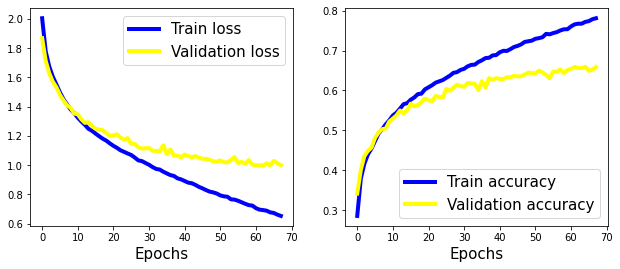

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/Tf_CNN/cnn_s/assets


In [ ]:
model_s = simple_model()
run_results(model_s, 's')

Далі ми можемо додати пакетну нормалізацію, щоб стабілізувати навчання і, можливо, прискорити процес навчання. Щоб компенсувати це прискорення, ми можемо змінити шаблон фіксованого параметру в дропауті на зростаючий. Також додамо регуляризацію l2 - застосування "штрафів" до параметрів або функції активації шару під час оптимізації.

In [ ]:
def tuned_model(with_drop, kernel = (3,3)):
	model = Sequential()
	model.add(Conv2D(32, kernel, activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
	model.add(Conv2D(32, kernel, activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	if with_drop:
		model.add(Dropout(0.2))
	model.add(Conv2D(64, kernel, activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(64, kernel, activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	if with_drop:
		model.add(Dropout(0.3))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer='l2'))
	model.add(Dense(10, activation='softmax', kernel_regularizer='l2'))
	
	opt = SGD(lr=0.001, momentum=0.9, nesterov=True)
 	# компіляція шарів
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

Epoch 1/100
200/200 [==============================] - 45s 225ms/step - loss: 0.6462 - accuracy: 0.7823 - val_loss: 1.0596 - val_accuracy: 0.6405
Epoch 2/100
200/200 [==============================] - 45s 226ms/step - loss: 0.6425 - accuracy: 0.7849 - val_loss: 1.0472 - val_accuracy: 0.6472
Epoch 3/100
200/200 [==============================] - 48s 238ms/step - loss: 0.6326 - accuracy: 0.7907 - val_loss: 1.0255 - val_accuracy: 0.6538
Epoch 4/100
200/200 [==============================] - 45s 225ms/step - loss: 0.6181 - accuracy: 0.7970 - val_loss: 1.0190 - val_accuracy: 0.6548
Epoch 5/100
200/200 [==============================] - 47s 234ms/step - loss: 0.6156 - accuracy: 0.7969 - val_loss: 1.0310 - val_accuracy: 0.6540
Epoch 6/100
200/200 [==============================] - 45s 224ms/step - loss: 0.6084 - accuracy: 0.7993 - val_loss: 1.0178 - val_accuracy: 0.6549
Epoch 7/100
200/200 [==============================] - 45s 225ms/step - loss: 0.6053 - accuracy: 0.7983 - val_loss: 1.0371 -

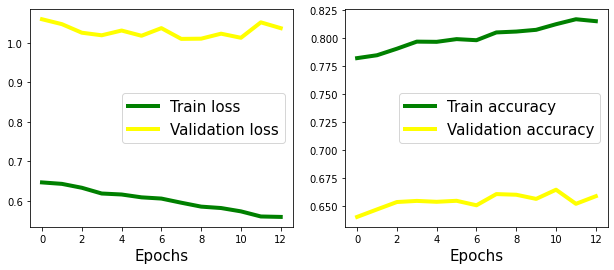

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/Tf_CNN/cnn_s/assets


In [ ]:
model_t = tuned_model(0)
run_results(model_s, 't1')

Модель (хоча і без дропауту) не вийшла краща за найпростішу - значить, треба підлаштувати параметри. Навіть регуляризації виявилося недостатньо для подолання перенавчання.


Втім, зміна розміру ядра та додавання дропауту не повпливали на покращення метрик. Тому може бути і інша причина - недостача даних. Подолати це можна було б додатковою генерацією картинок.


Epoch 1/100
200/200 [==============================] - 47s 234ms/step - loss: 0.5455 - accuracy: 0.8220 - val_loss: 1.0424 - val_accuracy: 0.6557
Epoch 2/100
200/200 [==============================] - 45s 226ms/step - loss: 0.5387 - accuracy: 0.8256 - val_loss: 1.0357 - val_accuracy: 0.6581
Epoch 3/100
200/200 [==============================] - 50s 248ms/step - loss: 0.5307 - accuracy: 0.8289 - val_loss: 1.0325 - val_accuracy: 0.6581
Epoch 4/100
200/200 [==============================] - 47s 234ms/step - loss: 0.5291 - accuracy: 0.8273 - val_loss: 1.0519 - val_accuracy: 0.6557
Epoch 5/100
200/200 [==============================] - 48s 240ms/step - loss: 0.5259 - accuracy: 0.8299 - val_loss: 1.0194 - val_accuracy: 0.6637
Epoch 6/100
200/200 [==============================] - 46s 228ms/step - loss: 0.5172 - accuracy: 0.8311 - val_loss: 1.0424 - val_accuracy: 0.6570
Epoch 7/100
200/200 [==============================] - 47s 237ms/step - loss: 0.5043 - accuracy: 0.8375 - val_loss: 1.0315 -

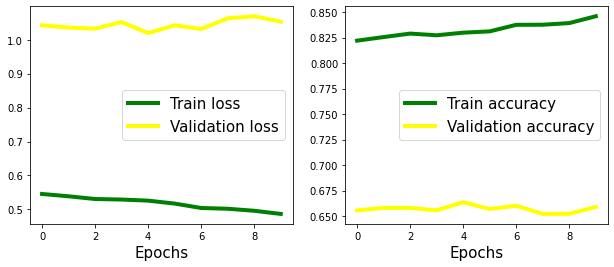

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/Tf_CNN/cnn_s/assets


In [ ]:
model_t = tuned_model(1, (5,5))
run_results(model_s, 't2')

In [ ]:
def tuned2_model(reg=tf.keras.regularizers.L2(0.001)):
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=reg, padding='same', input_shape=(32, 32, 3)))
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=reg, padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.3))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=reg, padding='same'))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=reg, padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer='l2'))
	model.add(Dropout(0.5))
	model.add(Dense(10, activation='softmax', kernel_regularizer='l2'))
	# compile model
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

Epoch 1/100
200/200 [==============================] - 51s 257ms/step - loss: 0.4314 - accuracy: 0.8658 - val_loss: 1.0764 - val_accuracy: 0.6576
Epoch 2/100
200/200 [==============================] - 52s 262ms/step - loss: 0.4269 - accuracy: 0.8697 - val_loss: 1.0796 - val_accuracy: 0.6596
Epoch 3/100
200/200 [==============================] - 49s 243ms/step - loss: 0.4179 - accuracy: 0.8719 - val_loss: 1.0633 - val_accuracy: 0.6647
Epoch 4/100
200/200 [==============================] - 46s 228ms/step - loss: 0.4155 - accuracy: 0.8729 - val_loss: 1.0806 - val_accuracy: 0.6572
Epoch 5/100
200/200 [==============================] - 48s 238ms/step - loss: 0.4033 - accuracy: 0.8774 - val_loss: 1.1147 - val_accuracy: 0.6530
Epoch 6/100
200/200 [==============================] - 47s 237ms/step - loss: 0.4036 - accuracy: 0.8774 - val_loss: 1.1152 - val_accuracy: 0.6553
Epoch 7/100
200/200 [==============================] - 45s 226ms/step - loss: 0.3951 - accuracy: 0.8804 - val_loss: 1.1004 -

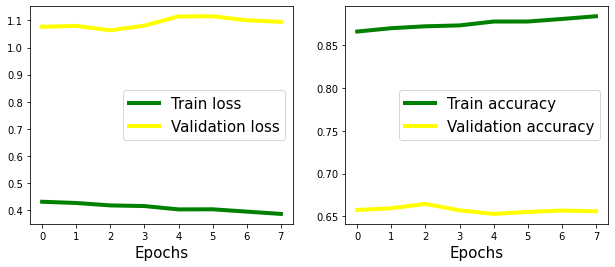

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/Tf_CNN/cnn_t/assets


In [ ]:
model_t = tuned2_model()
run_results(model_s, 't')

Вкрадемо з просторів інтернету зображення оленя та подивимося, чи зможе модель його розпізнати.

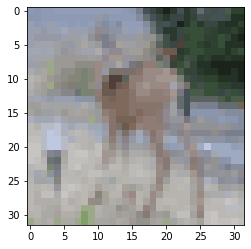

In [ ]:
img = tf.keras.utils.load_img("/content/drive/My Drive/Colab Notebooks/Tf_CNN/deer.png", target_size=(32, 32))
plt.imshow(img)
img = tf.keras.utils.img_to_array(img)
img = img.reshape(1, 32, 32, 3)
img = img.astype('float32') / 255.0

Те, що модель змогла спрогнозувати оленя правильно, є або везінням, або вказує на те, що це один із класів, які класифікуються найкраще.

In [ ]:
reconstructed_model = tf.keras.models.load_model("/content/drive/My Drive/Colab Notebooks/Tf_CNN/cnn_t/")
img_prob = reconstructed_model.predict(img)
img_pred = img_prob.argmax(axis=-1)
img_pred

array([4])

Тому з цікавості подивимося на оцінку f1 для кожного класу.

In [ ]:
y_prob = reconstructed_model.predict(X_test)
y_pred = y_prob.argmax(axis=-1)

print("F1 scores:", f1_score(y_test.argmax(axis=-1), y_pred, average=None))

F1 scores: [0.69480185 0.74450991 0.52425181 0.42431064 0.59396506 0.55229041
 0.74040857 0.70300752 0.75774648 0.72346786]
